In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *
from scipy.stats import genextreme
from scipy.special import gamma, gammainc

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## GEV

In [36]:
x = np.linspace(-4, 4, 100)

In [37]:
loc = 0
scale = 1
shape = -0.5

In [38]:
rv = genextreme(shape, loc=loc, scale=scale)

In [39]:
def gev_cdf(x, mu, sigma, xi):
    x = np.atleast_1d(x)
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = np.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g[x<support] = 0
    if xi < 0:
        g[x>support] = 1
    return g

In [40]:
a = 5

In [41]:
np.array(a)

array(5)

In [42]:
shape=0.1
loc=-2

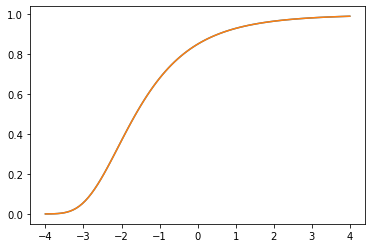

In [43]:
rv = genextreme(-shape, loc=loc, scale=scale)
truth = rv.cdf(x)
mine = gev_cdf(x, loc, scale, shape)
plt.plot(x, truth)
plt.plot(x, mine)

In [44]:
gev_cdf(0, loc, scale, shape)

array([0.85086178])

In [45]:
def crps_gev(y, mu, sigma, xi):
#     pdb.set_trace()
    py = gev_cdf2(y, mu, sigma, xi)
    p0 = gev_cdf2(np.array([0.]), mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - gammainc(1-xi, -np.log(py))
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * gammainc(1-xi, -2 * np.log(p0))
    )
    return crps

In [46]:
def crps_gev2(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)

    crps = (mu - y - sigma/xi) * (1 - 2*py)
    crps -= sigma / xi * gamma(1-xi)* (
        2**xi  - 2*gammainc(1-xi, -np.log(py))
    )

    return crps

In [47]:
def gev_cdf2(y, mu, sigma, xi):
    y = (y-mu)/sigma
    x = 1 + xi * y
    x[x < 0] = 0
    x = x**(-1/xi)
    return np.where(np.isinf(np.exp(-x)), 0, np.exp(-x))

In [48]:
def crps_gev3(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)
#     print(py)
    y = (y-mu)/sigma
    x = 1 + xi * y
    x[x < 0] = 0
    x = x**(-1/xi)
    py = np.exp(-x)
#     print(py)
    #     x = -np.log(gev_cdf(y, mu, sigma, xi))
    c1 = 2 * py - 1
    out = (y + 1/xi) * c1 + gamma(1 - xi) / xi * \
      (2 * gammainc(1 - xi, -np.log(py)) - 2**xi)

    return sigma*out

In [49]:
loc=2
scale=2
shape=0.9

In [50]:
x = np.linspace(-1, 10, 100)
c = crps_gev(x, loc, scale, shape)
c2 = crps_gev2(x, loc, scale, shape)
c3 = crps_gev3(x, loc, scale, shape)
min(c), min(c2)
# c = gev_cdf(x, loc, scale, -0.5)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/home/rasp/miniconda3/lib/py

(-0.6144794262147328, 1.1169302427714827)

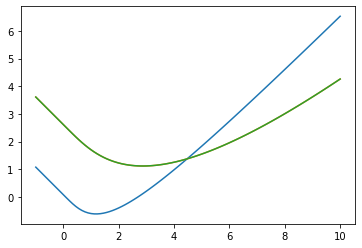

In [51]:
plt.plot(x, c)
plt.plot(x, c2)
plt.plot(x, c3)
# plt.axhline(0)

In [52]:
def lcgev_cdf(x, mu, sigma, xi):
    x = np.atleast_1d(x)
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = np.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g[x<support] = 0
    if xi < 0:
        g[x>support] = 1
    g[x<0] = 0
    return g

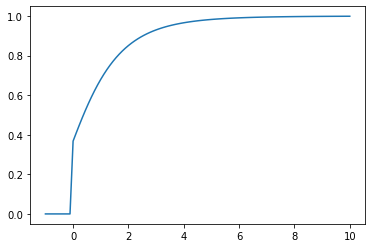

In [53]:
mine = lcgev_cdf(x, 0, 1, 0.1)
plt.plot(x, mine)

In [54]:
def crps_lcgev(y, mu, sigma, xi):
    py = gev_cdf(y, mu, sigma, xi)
    p0 = gev_cdf(0, mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - gammainc(1-xi, -np.log(py))
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * gammainc(1-xi, -2 * np.log(p0))
    )
    return crps

In [55]:
def crps_lcgev2(y, mu, sigma, xi):
#     pdb.set_trace()
    SCdSH = sigma/xi
    Gam1mSH = gamma(1-xi)
    
    probY = gev_cdf(y, mu, sigma, xi)
    prob0 = gev_cdf(0, mu, sigma, xi)
    
    T1 = (y-mu) * (2*probY-1) + mu * prob0**2
    T2 = SCdSH * ( 1-prob0**2 - 2**xi*Gam1mSH*gammainc(1-xi, -2*np.log(prob0)) )
    T3 = -2*SCdSH * ( 1-probY - Gam1mSH*gammainc(1-xi, -np.log(probY)) )
    
    return T1 + T2 + T3

In [56]:
x = np.linspace(0, 10, 100)

In [57]:
loc = 1
scale = 2
shape = 0.5
c = crps_lcgev(x, loc, scale, shape)
c2 = crps_lcgev2(x, loc, scale, shape)
# c = gev_cdf(x, loc, scale, -0.5)

In [58]:
np.min(c), np.min(c2)

(-0.1745196620826457, 0.7548749621658022)

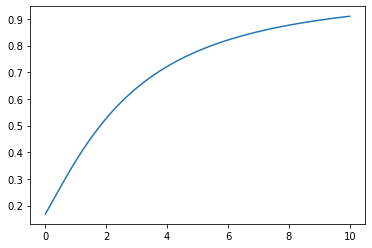

In [59]:
mine = lcgev_cdf(x, loc, scale, shape)
plt.plot(x, mine)

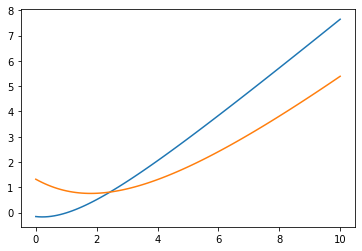

In [60]:
plt.plot(x, c)
plt.plot(x, c2)

## Loss function

In [ ]:
def gev_cdf(x, mu, sigma, xi):
    x = np.atleast_1d(x)
    t = (1+xi*((x-mu)/sigma))**(-1/xi)
    g = np.exp(-t)
    support = mu - sigma/xi
    if xi > 0:
        g[x<support] = 0
    if xi < 0:
        g[x>support] = 1
    return g

In [ ]:
def gev_cdf2(y, mu, sigma, xi):
    y = (y-mu)/sigma
    x = 1 + xi * y
    x[x < 0] = 0
    x = x**(-1/xi)
    return np.where(np.isinf(np.exp(-x)), 0, np.exp(-x))

In [130]:
def crps_lcgev2(y, mu, sigma, xi):
#     pdb.set_trace()
    SCdSH = sigma/xi
    Gam1mSH = gamma(1-xi)
#     print(Gam1mSH)
    
    probY = gev_cdf2(y, mu, sigma, xi)
    prob0 = gev_cdf2(0, mu, sigma, xi)
    
    T1 = (y-mu) * (2*probY-1) + mu * prob0**2
    T2 = SCdSH * ( 1-prob0**2 - 2**xi*Gam1mSH*gammainc(1-xi, -2*np.log(prob0)) )
    T3 = -2*SCdSH * ( 1-probY - Gam1mSH*gammainc(1-xi, -np.log(probY)) )
#     print(T1, T2, T3)
    return T1 + T2 + T3

In [93]:
def gev_cdf_tf(y, mu, sigma, xi):
    y = (y-mu)/sigma
    x = 1 + xi * y
#     x[x < 0] = 0
    x = tf.where(x<0, 0., x)
    x = x**(-1/xi)
    return tf.where(tf.math.is_inf(tf.exp(-x)), 0, tf.exp(-x))

In [27]:
def crps_lcgev_tf(y, mu, sigma, xi, dtype='float16'):
    SCdSH = sigma/xi
    Gam1mSH = tf.exp(tf.math.lgamma(1-xi))
#     print(Gam1mSH)
    
    probY = gev_cdf_tf(y, mu, sigma, xi)
    prob0 = gev_cdf_tf(0., mu, sigma, xi)
    
    igammaY = tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -tf.math.log(tf.cast(probY, 'float64'))), dtype)
    igamma0 = tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -2 * tf.math.log(tf.cast(prob0, 'float64'))), dtype)
    
    T1 = (y-mu) * (2*probY-1) + mu * prob0**2
    T2 = SCdSH * ( 1-prob0**2 - 2**xi*Gam1mSH*igamma0)
    T3 = -2*SCdSH * ( 1-probY - Gam1mSH*igammaY)
#     print(T1, T2, T3)
    return T1 + T2 + T3

In [62]:
def crps_lcgev_tf_old(y, mu, sigma, xi):
    py = lcgev_cdf_tf(y, mu, sigma, xi)
    p0 = lcgev_cdf_tf(0, mu, sigma, xi)

    crps = (mu - y) * (1 - 2*py)
    crps += mu * p0**2
    crps -= 2*sigma / xi * (
        1 - py - tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -tf.math.log(tf.cast(py, 'float64'))), 'float16')
    )
#     pdb.set_trace()

    crps += sigma / xi * (
        1 - p0**2 - 2**xi * tf.cast(tf.math.igamma(1-tf.cast(xi, 'float64'), -2 * tf.math.log(tf.cast(p0, 'float64'))), 'float16')
    )
    return crps

In [133]:
np.linspace(-0.5, 0.5, 101)

array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
        0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,
        0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,
        0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,  0.39,
        0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,
        0.49,  0.5 ])

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


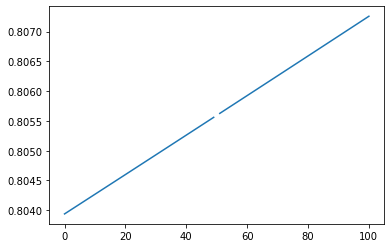

In [140]:
plt.plot(crps_lcgev2(np.array([0.5]), loc, scale, np.linspace(-0.005, 0.005, 101)))

In [115]:
crps_lcgev_tf(np.array([0, 0.5]), loc, scale, -shape, 'float32')

tf.Tensor(0.8862269, shape=(), dtype=float32)
tf.Tensor([0.62471414 0.261874  ], shape=(2,), dtype=float32) tf.Tensor(-1.5684395, shape=(), dtype=float32) tf.Tensor([1.8760314 1.9835544], shape=(2,), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.93230605, 0.67698884], dtype=float32)>

In [100]:
mu = tf.Variable(np.array([0.1]))
sigma = tf.Variable(np.array([1.]))
xi = tf.Variable(np.array([-0.5]))
y = np.array([0.5])

In [217]:
tf.constant(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [101]:
crps_lcgev_tf(y, mu, sigma, xi)

tf.Tensor([0.88622693], shape=(1,), dtype=float64)
tf.Tensor([0.03285899], shape=(1,), dtype=float64) tf.Tensor([-0.80249038], shape=(1,), dtype=float64) tf.Tensor([0.94748664], shape=(1,), dtype=float64)


<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.17785525])>

In [33]:
def crps_lcgev_loss(y_true, y_pred, dtype='float16'):
    mu, sigma, xi = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    sigma = tf.nn.relu(sigma)
    # Make sure xi isn't 0
#     eps = 1e-7
#     xi = tf.where(tf.abs(xi)<eps, eps, xi)
    # Keep xi in bounds
    xi = tf.clip_by_value(xi, -0.278, 0.999)
    return crps_lcgev_tf(y_true, mu, sigma, xi, dtype)

## Synthetic data

In [205]:
X = np.random.rand(1000).astype('float32')
y = np.maximum(X + np.random.rand(1000)/10, 0).astype('float32')

In [206]:
X.shape, y.shape

((1000,), (1000,))

In [207]:
model = tf.keras.models.Sequential([
    Dense(3, input_shape=(1,))
])

In [208]:
model.compile('adam', crps_lcgev_loss, run_eagerly=True)

In [209]:
model.fit(X, y, epochs=20)

Epoch 1/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4845
Epoch 2/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4831
Epoch 3/20
32/32 [==============================] - 1s 23ms/step - loss: 0.4833
Epoch 4/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4820
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4821
Epoch 6/20
32/32 [==============================] - 1s 23ms/step - loss: 0.4823
Epoch 7/20
32/32 [==============================] - 1s 24ms/step - loss: 0.4818
Epoch 8/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4820
Epoch 9/20
32/32 [==============================] - 1s 23ms/step - loss: 0.4822
Epoch 10/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4807
Epoch 11/20
32/32 [==============================] - 1s 23ms/step - loss: 0.4808
Epoch 12/20
32/32 [==============================] - 1s 22ms/step - loss: 0.4812
Epoch 13/20
32/32 [==================

In [210]:
p = model.predict(X)

In [211]:
p.max()

0.5796

In [212]:
p.min()

-1.186

In [213]:
p.shape

(1000, 3)

In [214]:
p[5]

array([-1.135 ,  0.555 ,  0.2113], dtype=float16)

In [215]:
crps_lcgev_loss(y, p)

<tf.Tensor: shape=(1000,), dtype=float16, numpy=
array([0.1493  , 0.7227  , 0.1381  , 0.2034  , 0.768   , 0.833   ,
       0.4111  , 0.099   , 0.522   , 0.2605  , 0.2598  , 0.3787  ,
       0.6704  , 0.661   , 0.3403  , 0.827   , 0.3633  , 0.7446  ,
       0.3743  , 0.202   , 0.674   , 0.5146  , 0.1131  , 0.3074  ,
       0.1989  , 0.5293  , 0.3867  , 0.547   , 0.5317  , 0.677   ,
       0.347   , 0.341   , 0.7324  , 0.717   , 0.0783  , 0.4426  ,
       0.2747  , 0.4924  , 0.7627  , 0.3198  , 0.11255 , 0.4111  ,
       0.8066  , 0.6025  , 0.6416  , 0.2251  , 0.1057  , 0.656   ,
       0.12274 , 0.3994  , 0.2423  , 0.498   , 0.517   , 0.1622  ,
       0.748   , 0.3127  , 0.752   , 0.3337  , 0.7676  , 0.4048  ,
       0.684   , 0.54    , 0.613   , 0.4814  , 0.5073  , 0.728   ,
       0.2854  , 0.3254  , 0.8716  , 0.3975  , 0.4973  , 0.742   ,
       0.835   , 0.12085 , 0.4634  , 0.02573 , 0.4917  , 0.3862  ,
       0.1249  , 0.2786  , 0.611   , 0.142   , 0.562   , 0.2285  ,
       0.1068

## Real data

In [5]:
args = load_args('../nn_configs/P/023-resnet_d3_tp_3d_param.yml')

In [6]:
args['train_tfr_files'] = None
args['valid_tfr_files'] = None
args['test_tfr_files'] = None
args['no_mean'] = True

In [7]:
dg_train = load_data(**args, only_test=True)

In [8]:
model = build_resnet(
    args['filters'], args['kernels'], input_shape=dg_train.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation'], long_skip=args['long_skip'],
    relu_idxs=args['relu_idxs'], categorical=args['is_categorical'], nvars=len(dg_train.output_idxs)
)

In [9]:
loss = create_lat_crps_lcgev(dg_train.data.lat, len(dg_train.output_idxs))

In [10]:
opt = keras.optimizers.Adam(args['lr'])

In [11]:
model.compile(opt, loss, run_eagerly=True)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 117) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  733952      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [14]:
model.fit(
    dg_train.tfr_dataset or dg_train,
    epochs=1,
)

 94/545 [====>.........................] - ETA: 2:24 - loss: 3.4646

KeyboardInterrupt: 

In [104]:
%debug

> <string>(3)raise_from()

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py(6653)raise_from_not_ok_status()
   6651   message = e.message + (" name: " + name if name is not None else "")
   6652   # pylint: disable=protected-access
-> 6653   six.raise_from(core._status_to_exception(e.code, message), None)
   6654   # pylint: enable=protected-access
   6655 

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py(10100)sub()
  10098         pass  # Add nodes to the TensorFlow graph.
  10099     except _core._NotOkStatusException as e:
> 10100       _ops.raise_from_not_ok_status(e, name)
  10101   # Add nodes to the TensorFlow graph.
  10102   _, _, _op, _outputs = _op_def_library._apply_op_helper(

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py(984)binary_op_wrapper()
    982     with ops.name_scope(None, op_name, [x, y]) as name:
    983       if isins

In [74]:
X, y = dg_train[0]

In [24]:
p = model(X)

In [28]:
p.shape

TensorShape([32, 32, 64, 3])

In [62]:
mu, sigma, xi = p[0, 0, 0].numpy()

In [76]:
dg_train.mean

<xarray.DataArray 'z' (level: 41)>
array([ 1.992378e+05,  1.010679e+05,  5.404291e+04,  4.060082e+04,
        2.890236e+04,  1.374821e+04,  7.024899e+03,  2.125645e+02,
        2.226092e+02,  2.524727e+02,  2.606488e+02,  2.669372e+02,
        2.741602e+02,  2.768541e+02,  5.829371e+00,  1.364833e+01,
        6.709670e+00,  4.908774e+00,  3.348938e+00,  1.364577e+00,
        5.319130e-01, -1.221293e-03,  1.757553e-02, -2.439905e-02,
       -3.297793e-02,  5.697536e-02,  1.478774e-01,  1.889071e-01,
        2.697075e-06,  5.553829e-05,  8.289706e-04,  1.502295e-03,
        2.364581e-03,  4.423556e-03,  5.914101e-03,  1.078743e+06,
        2.778698e+02,  0.000000e+00,  3.370783e-01,  3.794976e+02,
        0.000000e+00])
Coordinates:
  * level        (level) int64 50 250 500 600 700 850 925 50 ... 925 1 1 1 1 1 1
    level_names  (level) object ...
Attributes:
    tp_log:   0.001

In [63]:
y[0, 0, 0]

array([-2.2341916e-05], dtype=float32)

In [80]:
mu, sigma, xi

(2.1679688, 3.1933594, 5.4648438)

In [89]:
crps_lcgev2(y[0, 0, 0], mu, sigma, 0.99)

array([3.39307965])

In [77]:
crps_lcgev_loss(0, p, 'float32')

<tf.Tensor: shape=(32, 64, 3), dtype=float32, numpy=
array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, na